In [37]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from plotting_functions import *

# Set seed
torch.manual_seed(0)

In [38]:
from preprocessing import combine_data, add_time_features

# Generate file paths dynamically
start_date = pd.to_datetime("2024-10-08")
end_date = pd.to_datetime("2024-10-09")
date_range = pd.bdate_range(start=start_date, end=end_date)

data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

data_hft = combine_data(data_paths)
data_hft = add_time_features(data_hft)

data_hft.head()

,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,...,DMP_3,DMN_3,OLL3,OLL5,STOCHk_7_3_3,STOCHd_7_3_3,time_since_open,dow_1,dow_2,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-08 09:30:00-04:00,224.340,224.215,224.310,224.245,0.000290,1.0,10222.0,9928.0,6458.0,6563.0,...,0.170,0.000,0.075,0.095,84.210526,94.736842,0.0,1,0,0
2024-10-08 09:30:01-04:00,224.345,223.980,224.060,224.315,-0.001115,-1.0,13418.0,10781.0,9003.0,10779.0,...,0.170,0.235,0.335,0.335,21.917808,68.709445,1.0,1,0,0
2024-10-08 09:30:02-04:00,224.060,223.720,223.780,224.060,-0.001250,-1.0,40503.0,3679.0,38280.0,8789.0,...,0.095,0.495,0.340,0.340,9.600000,38.576112,2.0,1,0,0
2024-10-08 09:30:03-04:00,223.855,223.775,223.845,223.780,0.000290,1.0,3105.0,2284.0,3095.0,1392.0,...,0.000,0.495,0.060,0.060,20.000000,17.172603,3.0,1,0,0
2024-10-08 09:30:04-04:00,223.915,223.790,223.905,223.845,0.000268,1.0,3903.0,2083.0,3177.0,1407.0,...,0.060,0.260,0.125,0.125,29.600000,19.733333,4.0,1,0,0


In [39]:
# Features that require StandardScaler (price-dependent and volume-based)
standard_features = ['add_ask_size', 'add_bid_size', 'cancel_ask_size', 'cancel_bid_size',
                     'trade_ask_size', 'trade_bid_size', 'EMA_5', 'MA_5', 'Returns']

# Features that require MinMaxScaler (bounded indicators)
minmax_features = ['DMP_3', 'DMN_3', 'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'time_since_open']

unscaled_features = ["market_session", "dow_1", "dow_2"]

features = standard_features + minmax_features + unscaled_features

prediction_column = "Target"
batch_size = 100
epochs = 2
look_back = 60

In [40]:
# Data splitting

train_size = int(len(data_hft) * 0.7)
val_size = int(len(data_hft) * 0.1)
test_size = len(data_hft) - train_size - val_size

train_df = data_hft.iloc[:train_size, :]
val_df = data_hft.iloc[train_size : train_size + val_size, :]
test_df = data_hft.iloc[train_size + val_size :, :]

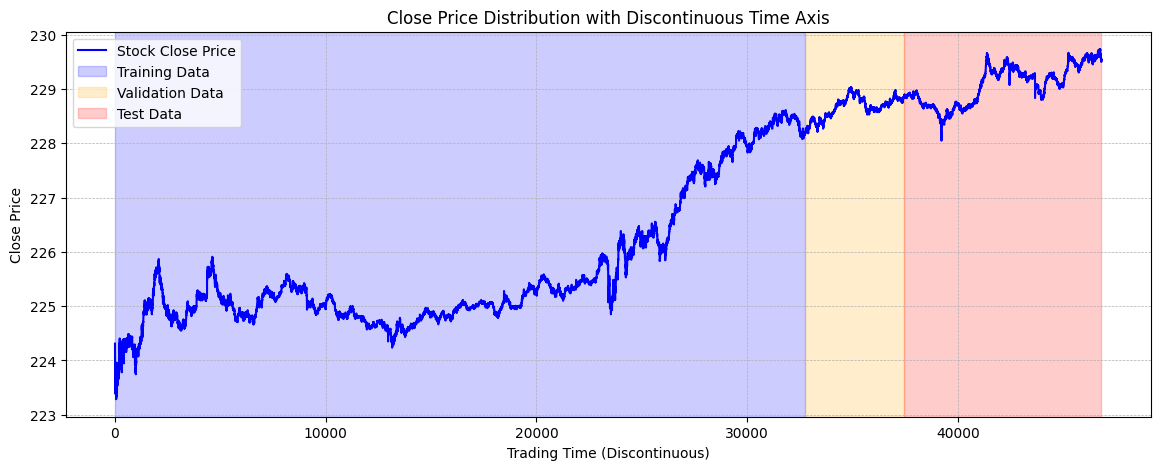

In [41]:
plot_close_price_split(data_hft, train_size, val_size)

In [42]:
# Data scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform on training data
train_standard_scaled = standard_scaler.fit_transform(train_df[standard_features])
train_minmax_scaled = minmax_scaler.fit_transform(train_df[minmax_features])

# Transform validation and test data
val_standard_scaled = standard_scaler.transform(val_df[standard_features])
val_minmax_scaled = minmax_scaler.transform(val_df[minmax_features])

test_standard_scaled = standard_scaler.transform(test_df[standard_features])
test_minmax_scaled = minmax_scaler.transform(test_df[minmax_features])

train_series_scaled = np.hstack((train_standard_scaled, train_minmax_scaled, train_df[unscaled_features].values))
val_series_scaled = np.hstack((val_standard_scaled, val_minmax_scaled, val_df[unscaled_features].values))
test_series_scaled = np.hstack((test_standard_scaled, test_minmax_scaled, test_df[unscaled_features].values))

In [43]:
# Custom PyTorch Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, look_back):
        self.data = data
        self.targets = targets
        self.look_back = look_back
    
    def __len__(self):
        return len(self.data) - self.look_back
    
    def __getitem__(self, index):
        x = self.data[index : index + self.look_back]
        y = self.targets[index + self.look_back]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long) 

In [44]:
# Create dataset and dataloaders
train_dataset = TimeSeriesDataset(train_series_scaled, train_df[prediction_column].values, look_back)
val_dataset = TimeSeriesDataset(val_series_scaled, val_df[prediction_column].values, look_back)
test_dataset = TimeSeriesDataset(test_series_scaled, test_df[prediction_column].values, look_back)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

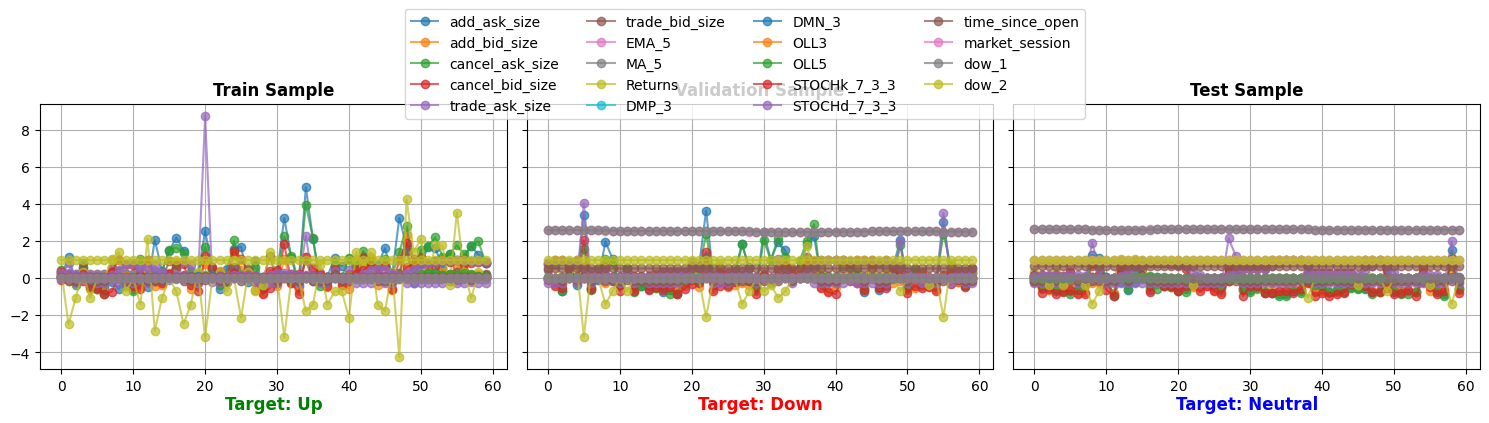

In [45]:
plot_samples([train_dataset, val_dataset, test_dataset], 
             ["Train Sample", "Validation Sample", "Test Sample"], features)


In [46]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 3)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :])  # Get last timestep output
        return self.softmax(x)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=len(features))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.0)
# optimizer = optim.Adam(model.parameters(), lr=0.005)


Training started...
Epoch 1/2 - Start time: 23:40:27
  Batch 1/328 (Total: 1/656) | Time elapsed: 0.11s
  Batch 328/328 (Total: 328/656) | Time elapsed: 37.35s
Epoch 1 completed in 41.48s
Train Loss: 1.0711, Train Acc: 0.4309
Val Loss: 1.0227, Val Acc: 0.5753

Epoch 2/2 - Start time: 23:41:08
  Batch 1/328 (Total: 329/656) | Time elapsed: 0.27s
  Batch 328/328 (Total: 656/656) | Time elapsed: 89.91s
Epoch 2 completed in 94.29s
Train Loss: 1.0498, Train Acc: 0.4496
Val Loss: 0.9985, Val Acc: 0.5706

Training completed in 135.77s



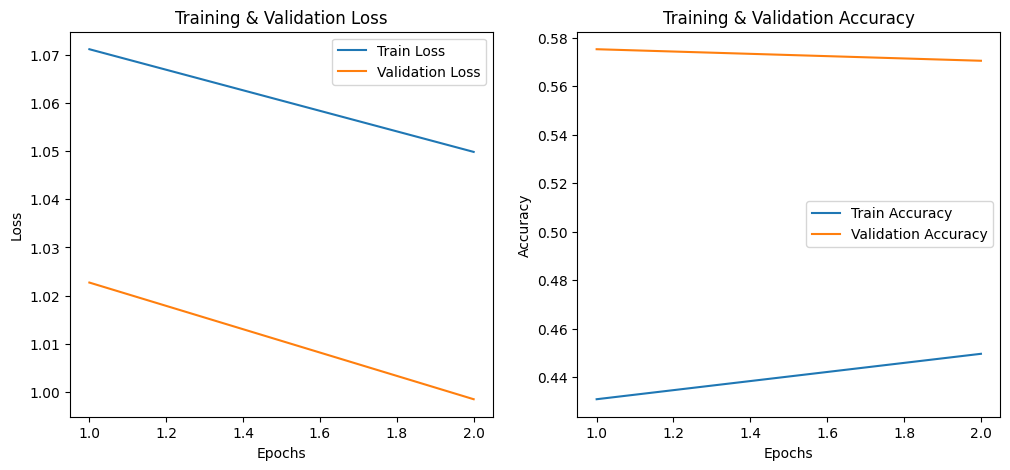

In [47]:
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    total_batches = len(train_loader) * epochs
    batch_count = 0

    print("Training started...")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch + 1}/{epochs} - Start time: {time.strftime('%H:%M:%S')}")
        
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            batch_count += 1

            optimizer.zero_grad()
            outputs = model(inputs)

            targets_shifted = targets + 1

            loss = criterion(outputs, targets_shifted)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            
            correct_train += (predicted == targets_shifted).sum().item()
            total_train += targets.size(0)

            if batch_idx % 500 == 0 or batch_idx == len(train_loader) - 1:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} (Total: {batch_count}/{total_batches}) | Time elapsed: {time.time() - epoch_start:.2f}s")

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)

                targets_shifted = targets + 1

                loss = criterion(outputs, targets_shifted)

                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)

                correct_val += (predicted == targets_shifted).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1} completed in {time.time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")
    
    print(f"Training completed in {time.time() - start_time:.2f}s\n")

    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model

# Train model
model = train_model(model, train_loader, val_loader, epochs=epochs)

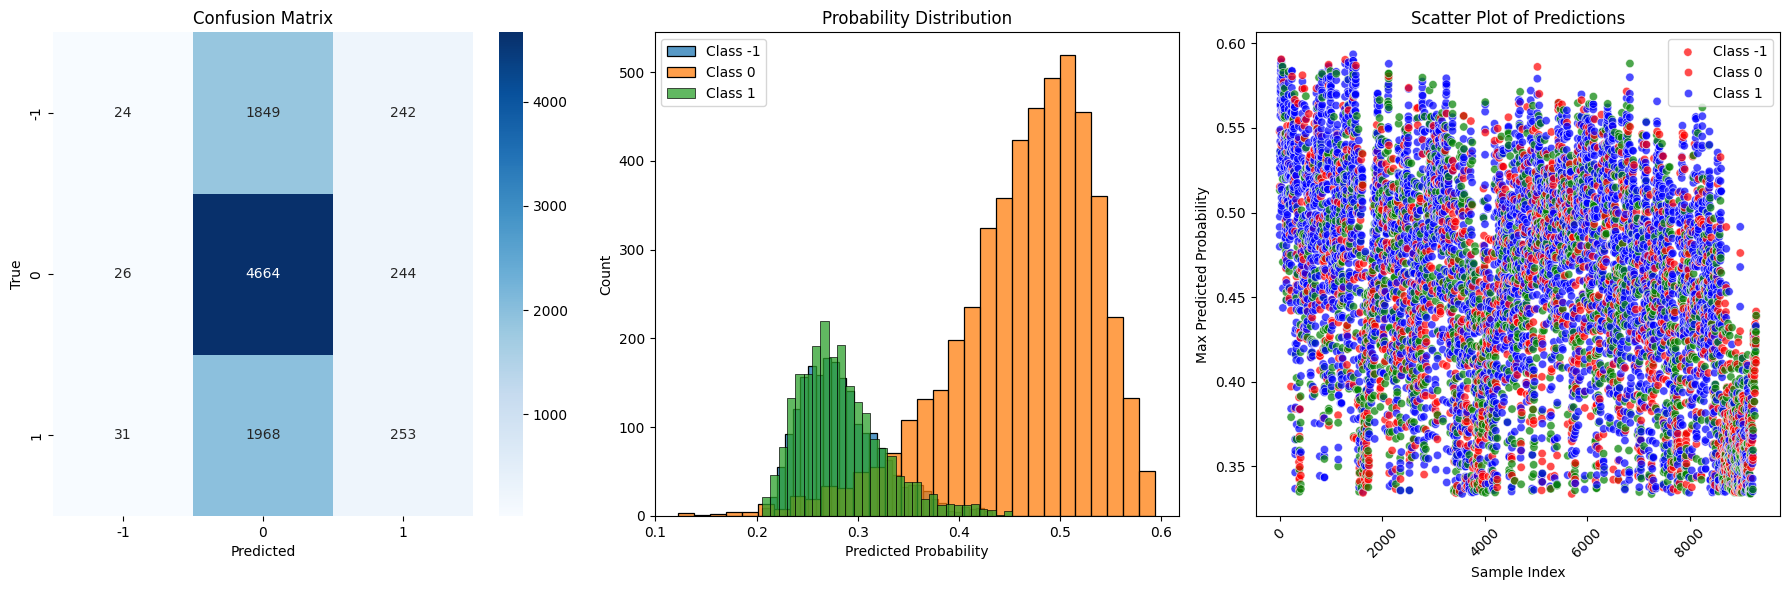

Accuracy: 0.5312
              precision    recall  f1-score   support

          -1       0.30      0.01      0.02      2115
           0       0.55      0.95      0.70      4934
           1       0.34      0.11      0.17      2252

    accuracy                           0.53      9301
   macro avg       0.40      0.36      0.30      9301
weighted avg       0.44      0.53      0.41      9301



In [48]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, test_loader):
    """Evaluates the model on a test set and plots relevant metrics."""
    model.eval()
    y_true, y_pred, log_probabilities = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            log_probabilities.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) - 1
    log_probabilities = np.array(log_probabilities)

    plot_evaluation_metrics(y_true, y_pred, log_probabilities)

    return y_true, y_pred, log_probabilities

y_true, y_pred, log_probabilities = evaluate_model(model, test_loader)

Baseline Strategy Accuracy: 0.4383


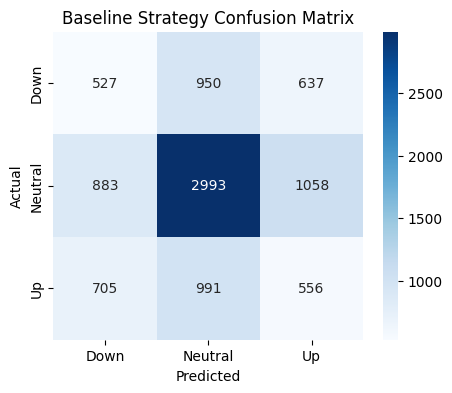

Accuracy: 0.4383
              precision    recall  f1-score   support

        -1.0       0.25      0.25      0.25      2114
         0.0       0.61      0.61      0.61      4934
         1.0       0.25      0.25      0.25      2252

    accuracy                           0.44      9300
   macro avg       0.37      0.37      0.37      9300
weighted avg       0.44      0.44      0.44      9300



In [49]:
def baseline_strategy(df):
    """Predicts tomorrow's target based on the sign and magnitude of today's return."""
    targets_shifted = df["Target"].shift(1)  # Use today's target to predict tomorrow's target
    baseline_preds = targets_shifted.fillna(1).astype(int)  # Fill NaN with neutral (1) and convert to int
    
    return baseline_preds[1:], df["Target"][1:]  # Align predictions with actual targets

# Assuming test_df is your test DataFrame and look_back is defined
# Evaluate Baseline Strategy
baseline_preds, baseline_targets = baseline_strategy(test_df.iloc[look_back:, :])
baseline_acc = accuracy_score(baseline_targets, baseline_preds)
print(f"Baseline Strategy Accuracy: {baseline_acc:.4f}")

# Plot baseline evaluation metrics
plot_baseline_evaluation_metrics(baseline_targets, baseline_preds)